# Debate dos presidenciáveis na Globo - 1º Turno - 2018

O debate ocorreu das 22h00 até por volta de 0h40 do dia 04 de Outubro de 2018 com a presença dos seguintes presidenciáveis:
- Alvaro Dias (Podemos)
- Ciro Gomes (PDT)
- Fernando Haddad (PT)
- Geraldo Alckmin (PSDB)
- Guilherme Boulos (PSOL)
- Henrique Meirelles (MDB)
- Marina Silva (Rede)

O candidato Jair Bolsonaro (PSL) foi convidado, mas não compareceu ao debate por recomendações médicas, entretanto no mesmo horário do debate na Rede Globo o candidato deu uma entrevista na Rede Record, portanto seu nome foi considerado nesta pesquisa.
***

Importação das bibliotecas necessárias e algumas configurações:

In [80]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy

pd.set_option('display.max_rows', 200_000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2_500)

nlp = spacy.load('pt')
nlp.max_length = 3_000_000

import warnings
warnings.filterwarnings('ignore')

### Dados intenção de votos aos presidenciáveis
***

Antes de começar as análises com os tweets, vamos dar uma olhada nos dados do Datafolha sobre os presidenciáveis até então. Fonte: https://www.poder360.com.br/banco-de-dados/

In [5]:
datafolha_est = pd.read_csv('datafolha_est.csv')
datafolha_rej = pd.read_csv('datafolha_rej.csv')

datafolha_est['data_pesquisa'] = datafolha_est['data_pesquisa'].apply(lambda x: pd.Timestamp(x).date())
datafolha_rej['data_pesquisa'] = datafolha_rej['data_pesquisa'].apply(lambda x: pd.Timestamp(x).date())

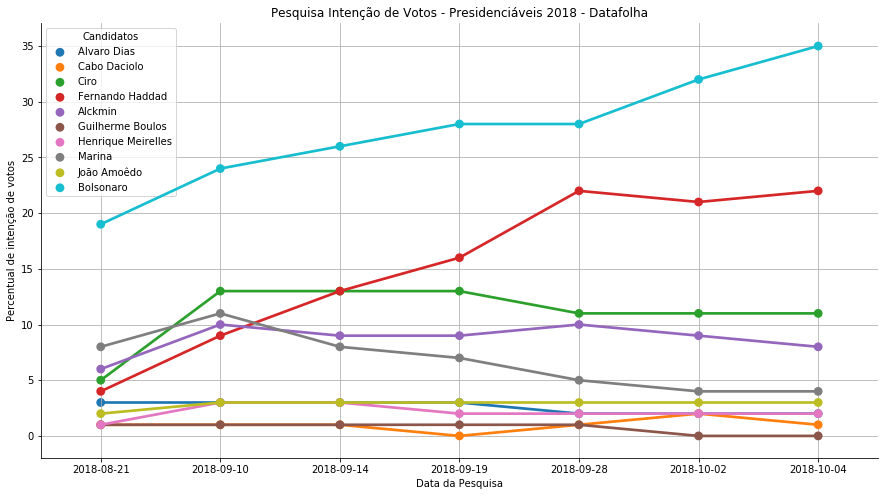

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = sns.pointplot(x='data_pesquisa',
                  y='percentual',
                  hue='candidato',
                  data=datafolha_est,
                  hue_order=['Alvaro Dias', 'Cabo Daciolo', 'Ciro', 'Fernando Haddad', 'Alckmin', 'Guilherme Boulos',
                             'Henrique Meirelles', 'Marina', 'João Amoêdo', 'Bolsonaro'],
                  ax=ax)

_ = ax.set(title='Pesquisa Intenção de Votos - Presidenciáveis 2018 - Datafolha',
           xlabel='Data da Pesquisa',
           ylabel='Percentual de intenção de votos')

_ = sns.despine()
_ = ax.grid(True)
_ = ax.legend(title='Candidatos')

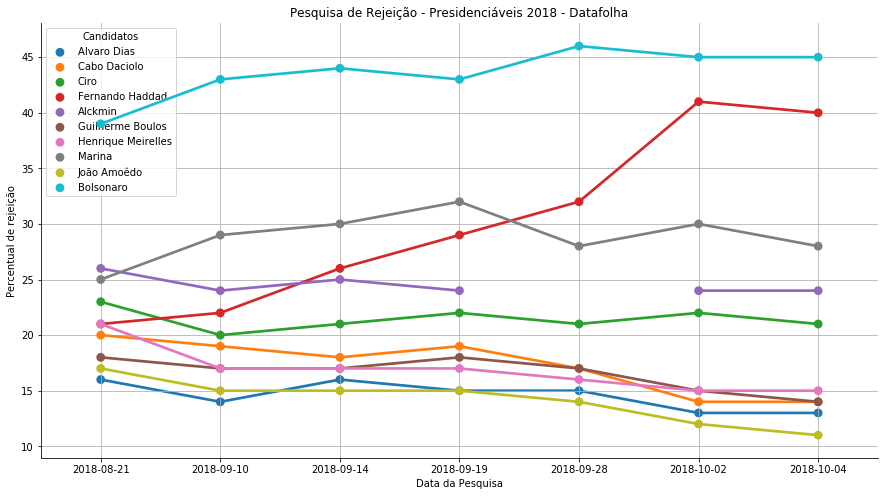

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))

_ = sns.pointplot(x='data_pesquisa',
                  y='percentual',
                  hue='candidato',
                  data=datafolha_rej,
                  hue_order=['Alvaro Dias', 'Cabo Daciolo', 'Ciro', 'Fernando Haddad', 'Alckmin', 'Guilherme Boulos',
                             'Henrique Meirelles', 'Marina', 'João Amoêdo', 'Bolsonaro'],
                  ax=ax)

_ = ax.set(title='Pesquisa de Rejeição - Presidenciáveis 2018 - Datafolha',
           xlabel='Data da Pesquisa',
           ylabel='Percentual de rejeição')

_ = sns.despine()
_ = ax.grid(True)
_ = ax.legend(title='Candidatos')

## Dados twitter durante o debate
***

In [8]:
# Leitura do dataset
tweets = pd.read_csv('../tweets_debate_globo_limpo.csv')

# Conversão da coluna 'datetime' em objeto datetime
tweets['datetime'] = tweets['datetime'].apply(pd.Timestamp)

# Adição de mais duas colunas ao dataset:'hour' e 'minute'
tweets['hour'] = tweets['datetime'].apply(lambda x: x.hour)
tweets['minute'] = tweets['datetime'].apply(lambda x: x.minute)

tweets.head()

,text,datetime,text_clean
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix
2,Boulos: A\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição
3,"O microfone do Meirelles caiu agora.\r\n\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30
4,"PROPOSTAS DE BOLSONARO\r\n- Fim do 13º e férias\r\n- Redução da licença maternidade\r\n- IR igual pra ricos e POBRES\r\n- Volta da CPMF\r\n- Fim do Bolsa Família e projetos sociais\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\n- Mais armas em circulação\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação


In [12]:
# Dimensão do dataset
tweets.shape

(508503, 5)

In [13]:
# Criação de variáveis que serão utilizadas no decorrer das análises
candidatos = ['alvaro', 'ciro', 'haddad', 'alckmin', 'boulos', 'meirelles', 'marina', 'bolsonaro']
display_candidatos = ['Álvaro Dias', 'Ciro Gomes', 'Fernando Haddad', 'Geraldo Alckmin', 'Guilherme Boulos', 'Henrique Meirelles', 'Marina Silva', 'Jair Bolsonaro']
colors = ['blue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'c']
map_names = {k: v for k, v in zip(candidatos, display_candidatos)}

In [92]:
# Funções que serão utilizads nas análises
import re
from collections import Counter

def mask_palavra_texto(palavra, texto):
    padrão = r'(^|[^\w]){}([^\w]|$)'.format(palavra)
    padrão = re.compile(padrão, re.IGNORECASE)
    matches = re.search(padrão, texto)
    return bool(matches)

def plot_contagem_candidatos(df, lista_candidatos):
    contagem = []
    palette = {k: v for k, v in zip(display_candidatos, colors)}    
    for candidato in lista_candidatos:
        contagem.append(df['text'].astype(str).apply(lambda x: mask_palavra_texto(candidato, x.lower())).sum())

    plot_df = pd.DataFrame({'Candidatos': candidatos, 'Contagem': contagem}).sort_values(by='Contagem', ascending=False)
    plot_df['Candidatos'] = plot_df['Candidatos'].map(map_names)
    fig, ax = plt.subplots(figsize=(15, 8))
    _ = sns.barplot(x='Candidatos', y='Contagem', data=plot_df, ax=ax, palette=palette)
    _ = ax.set(title='Contagem de tweets em que cada candidato foi citado')
    _ = sns.despine()

def verbos_candidatos(texto, candidato, qtde=5):
    sents = [sent for sent in texto.sents if candidato in sent.string.lower()]
    char_words = []
    for sent in sents: 
        for word in sent: 
            if candidato in word.string: 
                char_words.append(word)
    char_verbs = []
    for word in char_words: 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                char_verbs.append(ancestor.lemma_.strip())
    return Counter(char_verbs).most_common(qtde)

def adjetivos_candidatos(texto, candidato, qtde=5):
    sents = [sent for sent in texto.sents if candidato in sent.string.lower()]
    char_adjs = []
    for sent in sents: 
        for word in sent: 
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    char_adjs.append(child)
    return Counter(char_adjs).most_common(qtde)
                    
def frases_candidato(df, candidato, palavra, qtde=5):
    mask_cand = df['text_clean'].astype(str).apply(lambda x: mask_palavra_texto(candidato, x))
    mask_palavra = df['text_clean'].astype(str).apply(lambda x: mask_palavra_texto(palavra, x))
    return list(df[mask_cand & mask_palavra]['text'].head(qtde))

In [ ]:
plot_contagem_candidatos(tweets, candidatos)

Distribuição dos tweets por candidato durante o debate:

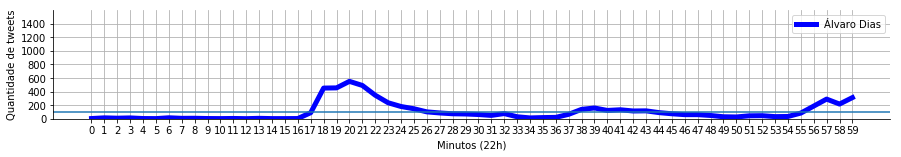

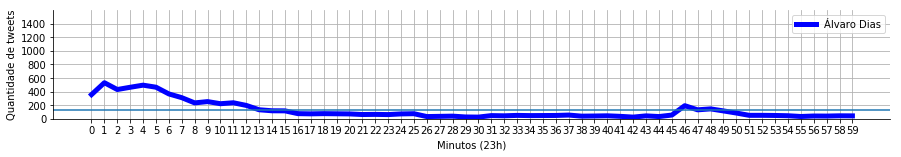

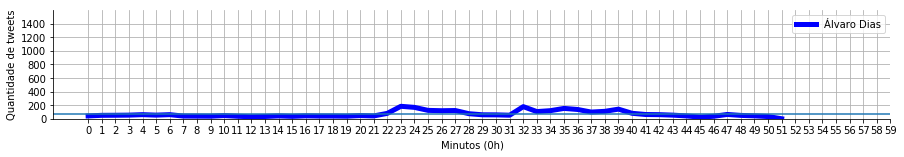

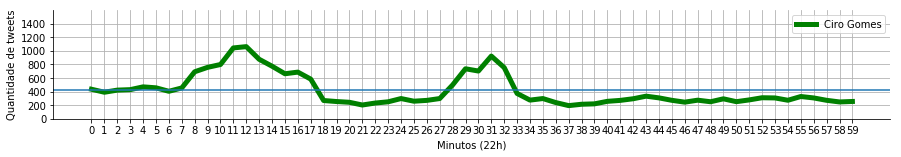

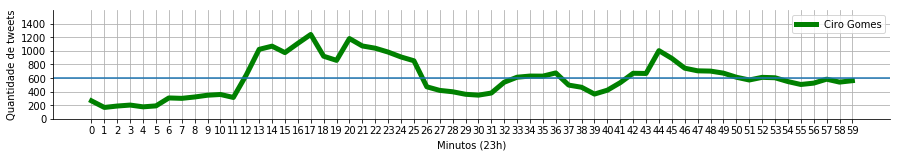

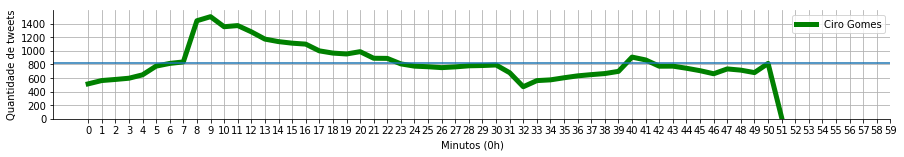

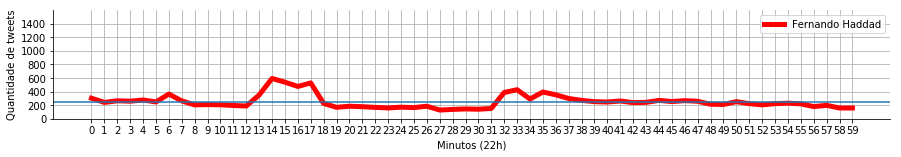

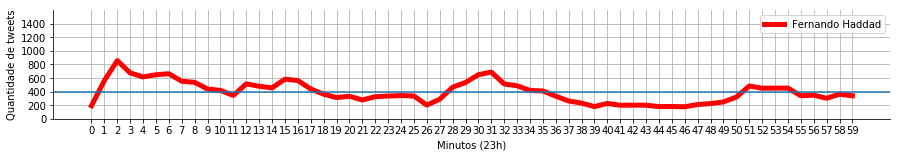

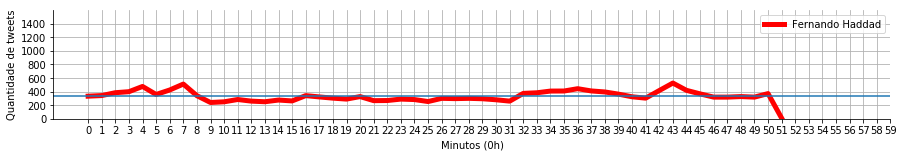

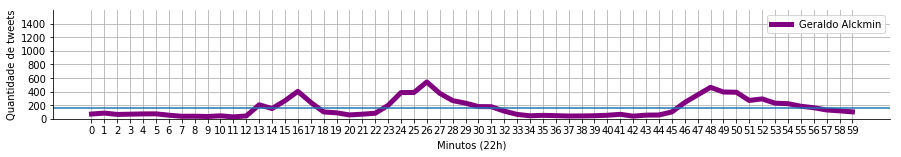

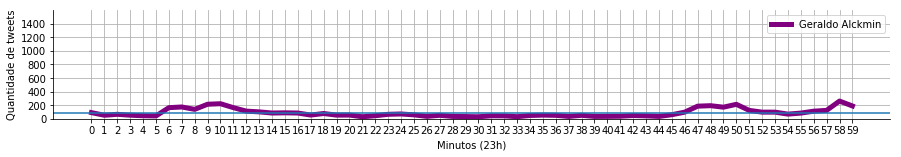

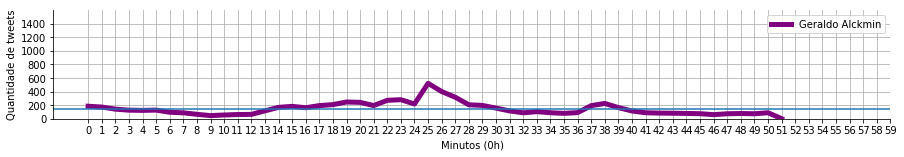

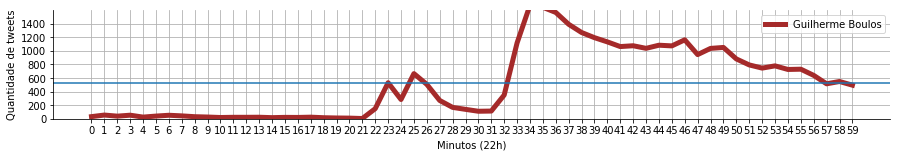

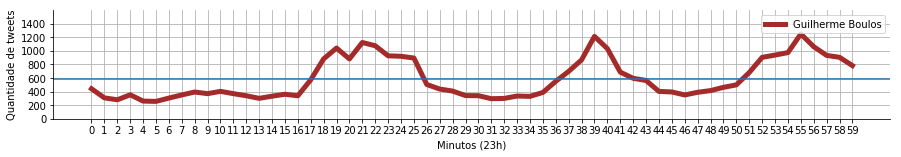

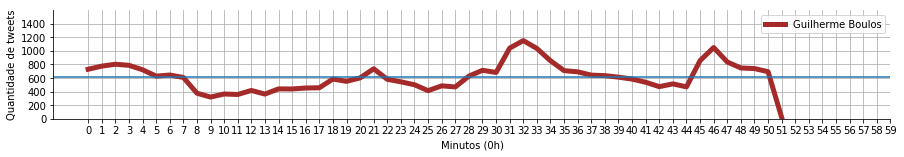

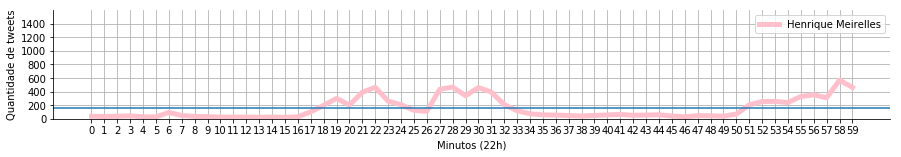

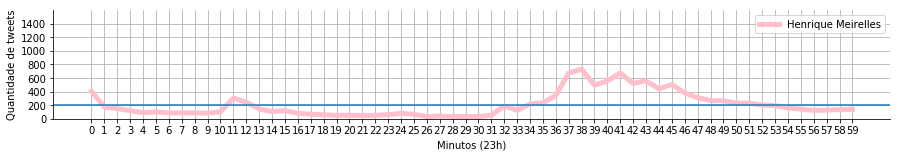

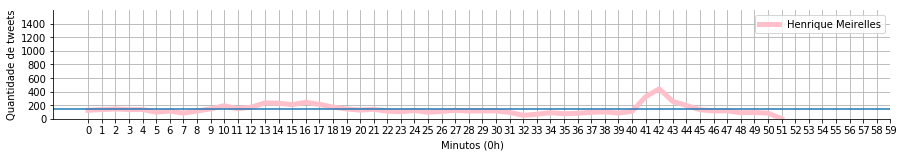

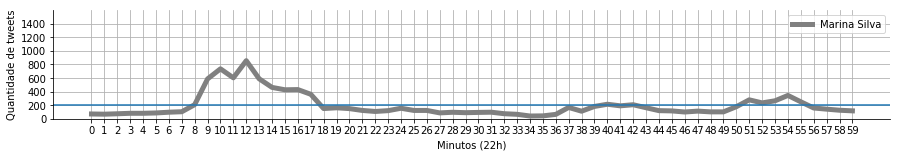

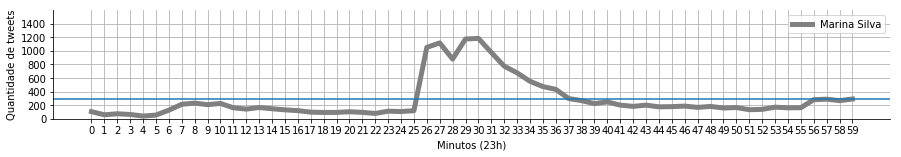

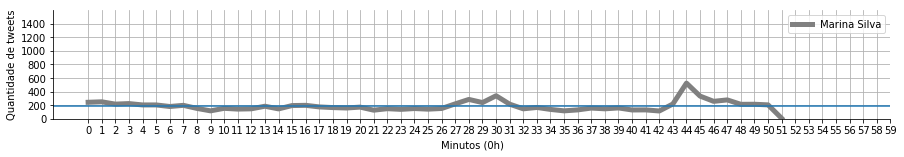

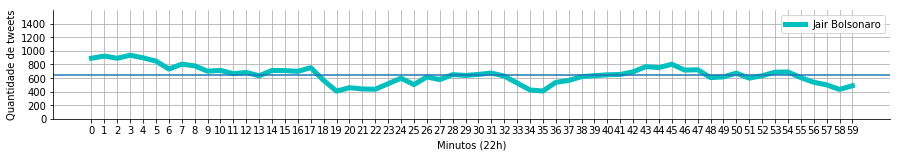

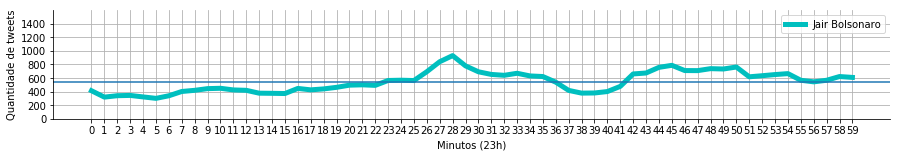

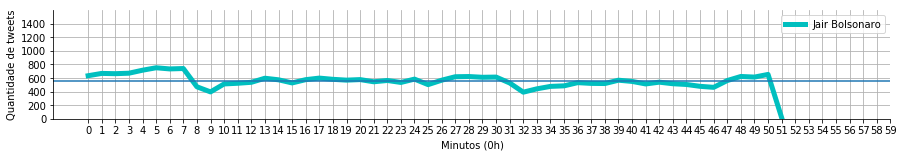

In [89]:
for candidato, c, nome in zip(candidatos, colors, display_candidatos):
    df_cand = tweets[tweets['text'].apply(lambda x: mask_palavra_texto(candidato, x))]
    for hora in [22, 23, 0]:
        fig, ax = plt.subplots(figsize=(15, 2))
        to_plot = df_cand[df_cand['hour']==hora]['minute'].value_counts().sort_index().reset_index()
        _ = sns.lineplot(x='index', y='minute', data=to_plot, ax=ax, color=c, label=nome, linewidth=5)

        _ = ax.set(xlabel='Minutos ({0}h)'.format(hora),
                   ylabel='Quantidade de tweets',
                   xticks=list(range(0, 60, 1)),
                   yticks=list(range(0, 1_500, 200)),
                   ylim=[0, 1_600])

        _ = ax.legend()
        _ = ax.grid(True)
        _ = ax.axhline(to_plot['minute'].mean())

        _ = sns.despine()
    _ = plt.subplots_adjust(hspace=0.4)

## Análise NLP
***

Por questão de limitações no processamento a análise dos tweets através de NLP será feita apenas nos tweets compreendidos nos espaços de tempo onde houve uma manifestação maior no twitter durante o debate em relação a cada candidato. É possível visualizar estas manifestações nos gráficos anteriores.<br>
Para não estender o notebook, será analisado apenas dois picos de manifestações no twitter por candidato.

In [49]:
def analise_nlp(df_tweets, candidato, hora, minutos_comeco, minutos_fim):
    df_cand = df_tweets[df_tweets['text'].apply(lambda x: mask_palavra_texto(candidato, x))]
    df = df_cand[(df_cand['hour']==hora) & ((df_cand['minute']>=minutos_comeco) & (df_cand['minute']<=minutos_fim))].copy()
    df_spacy = nlp(str(df['text']))
    nome = display_candidatos[candidatos.index(candidato)]
    verbos = verbos_candidatos(df_spacy, candidato)
    adjetivos = adjetivos_candidatos(df_spacy, candidato)
    print(' Horário:  {0}h{1} as {0}h{2}'.format(hora, minutos_comeco, minutos_fim))
    print(' Presidenciável:  {0}'.format(nome))
    print(' Quantidade de tweets:  {0}'.format(df.shape[0]))
    print(' Verbos mais utilizados:  {0}'.format(verbos))
    print(' Adjetivos mais utilizados:  {0}'.format(adjetivos))
    print('\n')
    if candidato == 'marina':
        candidato = 'marino'
    for verbo in verbos:
        tweets = frases_candidato(df, candidato, verbo[0])
        flag = 0
        if (len(tweets) != 0) & (flag<3):
            print(' Alguns tweets com o verbo "{0}":'.format(verbo[0]))
            for tweet in tweets:
                print('')
                print(u'\U0001f4ac   {0}'.format(tweet))
            print('\n')
            flag+=1

**Álvaro Dias**

In [20]:
analise_nlp(tweets, 'alvaro', 22, 17, 23)

 Horário:  22h17 as 22h23
 Presidenciável:  Álvaro Dias
 Quantidade de tweets:  2622
 Verbos mais utilizados:  [('ficar', 85), ('querer', 74), ('beber', 33), ('ter', 32), ('fazer', 28)]
 Adjetivos mais utilizados:  [(capital, 1), (feliz, 1), (belo, 1), (bêbado, 1), (igual, 1)]


 Alguns tweets com o verbo "ficar":

💬   Beber até ficar doido que nem o Alvaro Dias

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   O ALVARO DIAS ficou elogiando o William Bonner e esqueceu de perguntar e o tempo acabou KKKKKKKKKKKKKKKKKKKKKKKK

pqp mano olha o nivel dos candidatos

#DebateGlobo https://t.co/Mipb5ava0Q

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   alvaro dias passou 2hrs babando o ovo do william bonner que ficou sem tempo pra fazer pergunta, grito


 Alguns tweets com o verbo "querer":

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   Quero beber no fds ate ficar igual o Alvaro dias

💬   Meirelles tem 1 minu

In [21]:
analise_nlp(tweets, 'alvaro', 23, 0, 7)

 Horário:  23h0 as 23h7
 Presidenciável:  Álvaro Dias
 Quantidade de tweets:  3419
 Verbos mais utilizados:  [('tomar', 108), ('dar', 75), ('ter', 74), ('parecer', 67), ('dia', 61)]
 Adjetivos mais utilizados:  [(devido, 1), (podre, 1), (uísque, 1), (alvaro, 1), (maior, 1)]


 Alguns tweets com o verbo "tomar":

💬   cala a boca alvaro dias vai tomar no cu

💬   O ALVARO DIAS TÁ MAIS LOCO QUE O ROBOCOP TOMANDO BANHO DE MANGUEIRA

💬   A FELICIDADE DO ALVARO DIAS TOMANDO ESPORRO DO BONNER

💬   alvaro dias tomando varios esporros LKKKKKKKKKK #DebateNaGlobo

💬   alguem descobre oq foi q alvaro dias tomou antes do debate pq eu quero um pouco 

#DebateNaGlobo


 Alguns tweets com o verbo "parecer":

💬   o alvaro dias parece tio bebado em final de festa

💬   ai FINALMENTE um puxão de orelha no alvaro dias, parece que tá ali de brincadeira, eu hein

💬   alvaro dias tá parecendo tio bebado final de festa de família

💬   Alvaro Dias x Haddad ta parecendo clássico entre Flamengo x Vasco

💬   o alva

- Ciro Gomes

In [22]:
analise_nlp(tweets, 'ciro', 22, 8, 15)

 Horário:  22h8 as 22h15
 Presidenciável:  Ciro Gomes
 Quantidade de tweets:  6666
 Verbos mais utilizados:  [('votar', 84), ('querer', 65), ('ter', 62), ('começar', 48), ('amar', 47)]
 Adjetivos mais utilizados:  [(gomes, 1), (sensatas, 1), (primeira, 1), (marina, 1), (real, 1)]


 Alguns tweets com o verbo "votar":

💬   A primeira pergunta do Ciro já me fez sentir orgulho de votar nele

#DebateGlobo https://t.co/j9innHcixY

💬   Ciro: Marina é muito sensata pensa parecido comigo porém sou melhor votem em mim. 

#DebateNaGlobo

💬   Não vote contra o PT ❗

Não vote contra Bolsonaro 🚫

Vote a favor do Brasil 🇧🇷

Vote Ciro 1️⃣2️⃣
 #TsunamiCIRO https://t.co/nC0m7SuQeZ

💬   A primeira pergunta do Ciro já me fez sentir orgulho de votar nele

#DebateGlobo https://t.co/j9innHcixY

💬   Bolsonaristas já comemoram provável vitória sobre Haddad!

Novamente, DataFolha mostra que Bolsonaro só perde para Ciro.

Bolsonaro 44% x 43% Haddad 
Ciro 48% x 42% Bolsonaro

Os últimos dias são os mais decisivo

In [31]:
analise_nlp(tweets, 'ciro', 0, 7, 10)

 Horário:  0h7 as 0h10
 Presidenciável:  Ciro Gomes
 Quantidade de tweets:  5138
 Verbos mais utilizados:  [('olhar', 53), ('votar', 44), ('ter', 42), ('fazer', 33), ('DebateNaGlobo', 30)]
 Adjetivos mais utilizados:  [(severo, 1), (feminino, 1), (1005, 1), (maior, 1), (”, 1)]


 Alguns tweets com o verbo "olhar":

💬   Olha o Ciro tentando cativar o público feminino.

💬   Pesquisa datafolha:
Bolsonaro: 35%
Haddad: 22%
Ciro: 11%

Eu vou falar uma parada bem seria.   Ciro não cresce a 5 pesquisas. Está a três pesquisas com 11%.
 
Se a esquerda não abrir o olho não vai ter segundo turno para brigar.
Voto útil é  no Haddad sim.

💬   eu jamais conseguiria ser política olha esse tanto de gente em volta do Ciro eu já tinha infartado

💬   olha o ciro chavecando o bonner kkkkk

💬   Olha aí um segundo turno dos sonhos; Ciro X Haddad, discutindo propostas!


 Alguns tweets com o verbo "votar":

💬   JESUS teve 12 apóstolos, nao 17
isso eh um sinal
votem ciro 12

💬   Ciro - Acabei de ganhar seu vot

- Fernando Haddad

In [32]:
analise_nlp(tweets, 'haddad', 22, 13, 17)

 Horário:  22h13 as 22h17
 Presidenciável:  Fernando Haddad
 Quantidade de tweets:  2487
 Verbos mais utilizados:  [('ter', 26), ('falar', 25), ('dar', 17), ('falir', 16), ('votar', 15)]
 Adjetivos mais utilizados:  [(haddad, 1), (vivo, 1), (segundo, 1), (último, 1), (1º, 1)]


 Alguns tweets com o verbo "falar":

💬   meu deus o PT foi o governo + corporativista da história e o haddad acha que tem o direito de falar algo

💬   Haddad falando do governo do FHC 33203838299382 milhões de anos atrás. Eu quero saber do futuro, quero saber da pro… https://t.co/tUzQ3CM0sJ

💬   Haddad falou muito bem. PSDB entre outros partidos ajudaram a acabar com o governo de Dilma e a economia brasileira.

💬   Só eu acho que o Haddad tem preguiça de falar?

💬   Não sei se o Haddad tava falando e olhando pro Alckmin ou pra câmera #DebateNaGlobo


 Alguns tweets com o verbo "falir":

💬   Falam em política do medo e criticam com voto no medo, mas dizem que Haddad e Bolsonaro não terão como governar e que podem

In [33]:
analise_nlp(tweets, 'haddad', 23, 1, 8)

 Horário:  23h1 as 23h8
 Presidenciável:  Fernando Haddad
 Quantidade de tweets:  5111
 Verbos mais utilizados:  [('querer', 61), ('dizer', 41), ('botar', 36), ('ficar', 33), ('dar', 31)]
 Adjetivos mais utilizados:  [(dantesco, 1), (devido, 1), (nervoso, 1), (nervoso, 1), (favorita?\r\n-, 1)]


 Alguns tweets com o verbo "querer":

💬   e o alvaro dias querendo fazer o haddad de correio elegante

💬   Haddad dando a bronca que a gente queria no Álvaro Dias. Obrigado ícone!

💬   eu queria ter dois títulos pra votar no boulos e no haddad

💬   @andreazzaeditor O que Haddad quer dizer quando fala “vocês destruíram” falando da economia?

💬   "eu quero ficar bem de frente pro haddad" KKKKKKKKKKKKKKK mas gente  #DebateNaGlobo


 Alguns tweets com o verbo "botar":

💬   haddad botou o pau na mesa

💬   ÁLVARO DIAS BOTANDO MORAL. HADDAD, RESPONDA SÓ UMA DAS PERGUNTAS, DEIXE DE ENROLAR.

💬   Haddad usou a experiência do professor botando o aluno bagunceiro e desrespeitoso no lugar #DebateNaGlobo

💬

- Geraldo Alckmin

In [34]:
analise_nlp(tweets, 'alckmin', 22, 23, 28)

 Horário:  22h23 as 22h28
 Presidenciável:  Geraldo Alckmin
 Quantidade de tweets:  2157
 Verbos mais utilizados:  [('ter', 37), ('falar', 21), ('parecer', 19), ('falir', 14), ('querer', 13)]
 Adjetivos mais utilizados:  [(geraldo, 1), (igual, 1), (https://t.co/8I1LcDYYUd, 1), (necessária, 1), (trabalhista, 1)]


 Alguns tweets com o verbo "falar":

💬   Alckmin falando que a reforma trabalhista foi "necessária" e não retira direitos dos trabalhadores.

meus parabéns… https://t.co/qrTz71xlco

💬   a gente ouve alckmin falando e fica EM SITUAÇÃO DE AGREDIR UM IDOSO

💬   O Alckmin falando da TV do Lula
O Boulos falando de 50 tons de temer
O Ciro falando do Ceará
O Meirelles pedindo pr… https://t.co/CqX6szshj1

💬   "Alckmin, nós estamos de fato em lados opostos. Você é da turma dos privilégios e eu dos direitos. Falar que a reforma não tirou direitos é brincar com o povo. Quem está procurando emprego sabe a dificuldade que é encontrar um com carteira assinada."#DebateNaGlobo #BoulosNaGlobo


In [35]:
analise_nlp(tweets, 'alckmin', 0, 24, 27)

 Horário:  0h24 as 0h27
 Presidenciável:  Geraldo Alckmin
 Quantidade de tweets:  1458
 Verbos mais utilizados:  [('falar', 30), ('ter', 23), ('entender', 16), ('achar', 11), ('dizer', 10)]
 Adjetivos mais utilizados:  [(comum, 1), (primeira, 1), (\r\n\r\nA, 1), (pequeninos, 1), (#, 1)]


 Alguns tweets com o verbo "falar":

💬   Que bonito isso que  o Alckmin falou do filho que a mãe ama mais poetisou

💬   ALCKMIN E ÁLVARO DIAS FALANDO DE EDUCAÇÃO????

VIROU STAND UP AGORA????????

💬   @mizanzuk Juro que quando o Alckmin falou, "olha, Álvaro, nós temos em comum..." eu pensei "a surra que demos nos professores".

💬   Alckmin, ladrão de merenda, falando que quer ser o presidente dos pequeninos 

A desfaçatez desses ARROMBADOS desconhece limites

💬   Botaram o Alckmin e Álvaro Dias falando sobre educação e os professores já sentitam uma pancada. #DebateNaGlobo #eleições2018


 Alguns tweets com o verbo "entender":

💬   passo a maior parte do tempo das respostas do alckmin tentand entender

- Guilherme Boulos

In [37]:
analise_nlp(tweets, 'boulos', 22, 33, 37)

 Horário:  22h33 as 22h37
 Presidenciável:  Guilherme Boulos
 Quantidade de tweets:  7386
 Verbos mais utilizados:  [('falar', 87), ('querer', 79), ('votar', 63), ('fazer', 60), ('falir', 57)]
 Adjetivos mais utilizados:  [(arrepiante, 1), (sensato, 1), (super, 1), (dramático, 1), (boulos, 1)]


 Alguns tweets com o verbo "falar":

💬   Boulos falando o que precisa ser falado. Dá até vontade de chorar. #DebateNaGlobo

💬   BOULOS FALANDO SÓ VERDADES #DebateNaGlobo

💬   pq o boulos fecha o olho p falar #DebateNaGlobo

💬   Arrepiei com o Boulos falando. Se um dia critiquei ele, não me lembro

💬   O BOULOS FALANDO PARECE Q TO ASSISTINDO UMA MINISSÉRIE DA GLOBO


 Alguns tweets com o verbo "querer":

💬   boulos vc quer o mundo? eu te dou

💬   Fico indignado com esse “showzinho” do Boulos MST, fala que não quer viver na ditadura e apoia a porra do Maduro! #DebateNaGlobo

💬   Boulos dizendo que não quer suas filhas vivendo numa “ditadura” mas não cansa de defender o atual governo Venezuelano 🤣

In [38]:
analise_nlp(tweets, 'boulos', 23, 18, 25)

 Horário:  23h18 as 23h25
 Presidenciável:  Guilherme Boulos
 Quantidade de tweets:  7743
 Verbos mais utilizados:  [('querer', 145), ('falir', 114), ('ter', 93), ('esperar', 86), ('falar', 61)]
 Adjetivos mais utilizados:  [(próximas, 1), (#, 1), (claro, 1), (ruim, 1), (vamo, 1)]


 Alguns tweets com o verbo "querer":

💬   meu pai queria votar em branco mas começou a elogiar o boulos e ciro 👀

💬   Ciro trabalhou com Marina, que foi do partido do Haddad (apoiado por Boulos) que elegeu Temer, que chamou o Meirelles e o partido do Alckmin, que teve apoio do Álvaro (congressista há anos como Bolsonaro). Quer renovar? Só tem um: @joaoamoedonovo

💬   Não querem chamar o Ciro e nem o Boulos pq sabem que os 2 comem o cu sem lubrificante mesmo

#DebateNaGlobo https://t.co/WjzSCUBMmp

💬   “Nós não queremos construir presídios, queremos construir escolas” BOULOS, Guilherme. O futuro da política brasileira.

💬   Resumo do debate:

Haddad: acordou e foi pra briga
Ciro: ninguém quer encarar
Marina:

- Henrique Meirelles

In [44]:
analise_nlp(tweets, 'meirelles', 22, 27, 31)

 Horário:  22h27 as 22h31
 Presidenciável:  Henrique Meirelles
 Quantidade de tweets:  2094
 Verbos mais utilizados:  [('tava', 55), ('ter', 35), ('conseguir', 35), ('parecer', 33), ('cair', 32)]
 Adjetivos mais utilizados:  [(agora.\r\n\r\nO, 1), (1503, 1), (segundo, 1), (cômico, 1), (igual, 1)]


 Alguns tweets com o verbo "tava":

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil

💬   o meirelles certeza q tava em um dos barco q veio de portugual colonizar o brasil


 Alguns tweets com o verbo "conseguir":

💬   O ALVARO DIAS NAO CONSEGUIU PERGUNTAR E O MEIRELLES TEM QUE RESPONDER UMA PERGUNTA QUE NAO ACONTECEU

💬   henrique meirelles não está conseguindo nem mais segurar o microfone coitado.

In [45]:
analise_nlp(tweets, 'meirelles', 22, 55, 59)

 Horário:  22h55 as 22h59
 Presidenciável:  Henrique Meirelles
 Quantidade de tweets:  2022
 Verbos mais utilizados:  [('ter', 53), ('parecer', 37), ('falir', 28), ('dar', 22), ('chamar', 20)]
 Adjetivos mais utilizados:  [(longas, 1), (#, 1), (legal, 1), (engraçado, 1), (calculista, 1)]


 Alguns tweets com o verbo "parecer":

💬   o meirelles e o alvaro parece que acabaram de sair da endoscopia

💬   essa dobradinha henrique meirelles alvaro dias ta parecendo aqueles aluno da escolinha do professor raimunfo que nao consegue segurar o riso

💬   gente alguem tira o meirelles meu deus parece uma lesma falando coitado

💬   Meirelles X Álvaro Dias faz Americano X ibis parecer aceitável

💬   essa dobradinha henrique meirelles alvaro dias ta parecendo aqueles aluno da escolinha do professor raimunfo que nao consegue segurar o riso


 Alguns tweets com o verbo "falir":

💬   Meirelles fala devagar pra enrolar ou porque não tem fôlego?

💬   alvaro dias e meirelles os dois a 80 km qual dos dois c

- Marina Silva

In [47]:
analise_nlp(tweets, 'marina', 22, 9, 17)

 Horário:  22h9 as 22h17
 Presidenciável:  Marina Silva
 Quantidade de tweets:  5049
 Verbos mais utilizados:  [('querer', 113), ('insistir', 73), ('achar', 45), ('ter', 43), ('falar', 39)]
 Adjetivos mais utilizados:  [(seringueira, 1), (senadora, 1), (ministra\r\nMais, 1), (jovem, 1), (sensatas, 1)]


 Alguns tweets com o verbo "querer":

💬   Queria Marina como vice do Ciro ao invés da Miss motosserra 😩

💬   ciro presidente marina vice, esse é o brasil que eu quero pro futuro

💬   Queria que alguém insistisse em mim como a Marina insiste em ser presidente

💬   queria o ciro e a marina no segundo turno, brasileiros pq me mataram? #DebateNaGlobo https://t.co/ML2l0u2bfT

💬   Eu quero ver é lavação de roupa suja e não pergunta pra Marina pff


 Alguns tweets com o verbo "insistir":

💬   Queria que alguém insistisse em mim como a Marina insiste em ser presidente

💬   queria alguém   insistindo   em mim 
igual a marina silva insiste   em ser presidente

💬   queria alguém   insistindo   em 

In [50]:
analise_nlp(tweets, 'marina', 23, 26, 34)

 Horário:  23h26 as 23h34
 Presidenciável:  Marina Silva
 Quantidade de tweets:  8384
 Verbos mais utilizados:  [('falar', 155), ('amarelar', 96), ('ter', 85), ('dar', 55), ('querer', 54)]
 Adjetivos mais utilizados:  [(DEMAIS, 1), (da, 1), (melhor, 1), (miss, 1), (sustentabilidade, 1)]


 Alguns tweets com o verbo "falar":

💬   Marina Silva falando que o Bolsonaro amarelou KKKKKKK

💬   Marina falou bonito agora #DebateNaGlobo

💬   MARINA FALANDO QUE BOLSONARO AMARELOU. QUE DEU UMA ENTREVISTA PARA A RECORD E NÃO APARECEU NO DEBATE  #DebateNaGlobo https://t.co/sU7bcFPRIU

💬   Marina falou que Bolsonaro Amarelou, deu entrevista para Record e não para o #DebateNaGlobo. ÍCONE! https://t.co/ecSmm1oOwR

💬   marina falando “record” ao invés de “em outra emissora” na globo 

#DebateNaGlobo https://t.co/K9E27meGxk


 Alguns tweets com o verbo "amarelar":

💬   Marina Silva falando que o Bolsonaro amarelou KKKKKKK

💬   marina silva "o candidato bolsonaro amarelou deu uma entrevista para record e 

- Jair Bolsonaro

In [51]:
analise_nlp(tweets, 'bolsonaro', 22, 0, 8)

 Horário:  22h0 as 22h8
 Presidenciável:  Jair Bolsonaro
 Quantidade de tweets:  7703
 Verbos mais utilizados:  [('votar', 112), ('ter', 45), ('dizer', 33), ('destruir', 31), ('querer', 29)]
 Adjetivos mais utilizados:  [(maior, 1), (primeiro, 1), (negro, 1), (bolsonaro, 1), (primeiro, 1)]


 Alguns tweets com o verbo "votar":

💬   Meus dois principais argumentos pró-Ciro são 

- Não é do PT
- Não é o Bolsonaro

Meu voto é #TsunamiCIRO. Entretanto, se for o Haddad pro segundo turno: https://t.co/Cdw0JFQNCi

💬   Candidato do Bolsonaro é o Olímpio. O voto tem que ser nele. Já disse, mas vou repetir: A aprovação de um Ministro do STF passa pelo Senado. Bolsonaro precisará ter maioria. Incrível como muitos não entendem isso! https://t.co/BB7rVK43Xr

💬   "Ciranda, cirandinha,
Vamos todos cirandar.
Nem PT, nem Bolsonaro
Vote 12 pra mudar"

#TsunamiCIRO https://t.co/YxS3TDPHba

💬   Metade dos evangélicos vota em Bolsonaro. https://t.co/Bqs2QKRqOw

💬   eu me indigno cada vez mais em ver uma mu

In [52]:
analise_nlp(tweets, 'bolsonaro', 23, 26, 30)

 Horário:  23h26 as 23h30
 Presidenciável:  Jair Bolsonaro
 Quantidade de tweets:  3934
 Verbos mais utilizados:  [('amarelar', 128), ('fazer', 97), ('falar', 48), ('querer', 32), ('dizer', 31)]
 Adjetivos mais utilizados:  [(pesquisas, 1), (bolsonaro, 1), (https://t.co/KutxOFYWeS, 1), (bolsonaro, 1), (trabalhador, 1)]


 Alguns tweets com o verbo "amarelar":

💬   Marina Silva falando que o Bolsonaro amarelou KKKKKKK

💬   "eu faria essa pergunta pro candidato bolsonaro que amarelou e não está no debate, mas tá dando entrevista pra record" #DebateNaGlobo https://t.co/709SwZPuCq

💬   #MARINASILVA, #BOLSONARO NÃO AMARELOU. Ele levou uma facada de Adélio Silva. Deveria ficar calada, parar de dizer a… https://t.co/Lk0j2Mba48

💬   #DebateNaGlobo Marina repete que Bolsonaro amarelou e é aplaudida https://t.co/KutxOFYWeS

💬   Bolsonaro AMARELOU


 Alguns tweets com o verbo "falar":

💬   Ciro Gomes é um canalha, participou de 2 debates com o Bolsonaro, porque não falou isso que está falando nes

## Análise de Sentimentos

In [53]:
# Datasets train e holdout anteriormente tratados (notebook Preprocessing)
train = pd.read_csv('../tweets_train.csv')
holdout = pd.read_csv('../tweets_holdout.csv')

In [54]:
train.head()

,text,datetime,text_clean,sentiment
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho,0.0
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix,-1.0
2,Boulos: A\r\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição,1.0
3,"O microfone do Meirelles caiu agora.\r\r\n\r\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30,-1.0
4,"PROPOSTAS DE BOLSONARO\r\r\n- Fim do 13º e férias\r\r\n- Redução da licença maternidade\r\r\n- IR igual pra ricos e POBRES\r\r\n- Volta da CPMF\r\r\n- Fim do Bolsa Família e projetos sociais\r\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\r\n- Mais armas em circulação\r\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação,-1.0


In [55]:
holdout.head()

,text,datetime,text_clean
0,álvaro dias perguntando pro meirelzzZZZzzzzZZzzZZZzz,2018-10-04 22:18:06+00:00,álvaro perguntar pro meirelzzzzzzzzzzzzzzzzzz
1,Ninguém falou sobre isso até agora no debate. Acabar com desmatamento tão importante quanto reduzir emissões. https://t.co/2MFFikdbFW,2018-10-04 23:12:08+00:00,ninguém falar sobrar o debater acabar desmatamento importante quantum reduzir emissão
2,Fernando Haddad destruiu o Alvaro Dias. Não que isso seja difícil. #DebateNaGlobo,2018-10-04 23:53:50+00:00,fernando haddad destruir o alvaro difícil debatenaglobo
3,a fala histórica do boulos contra a ditadura. pra rever e se emocionar de novo #DebateNaGlobo \r\r\nhttps://t.co/jsJRjjhKIi,2018-10-05 00:17:54+00:00,o falir histórico boulos o ditadura pra rever e emocionar debatenaglobo
4,o cu do bozo encontra-se arrombado depois dessa fala do ciro,2018-10-05 00:10:30+00:00,o cu bozo encontrar arrombar d falir ciro


In [56]:
train.shape

(1000, 4)

- Pré-processamento dos datasets:

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [59]:
n_train = train.shape[0]
full = pd.concat([train, holdout], ignore_index=True, sort=False)
full = full['text_clean'].copy()

In [60]:
full.shape

(508118,)

In [61]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(full)

In [62]:
tfidf = TfidfTransformer()
X = tfidf.fit_transform(X)

In [63]:
train_tfidf = X[:n_train, :]
holdout_tfidf = X[n_train:, :]
y = train['sentiment']

- Random Forest Classifier

In [64]:
from sklearn.model_selection import cross_val_score

In [65]:
from sklearn.ensemble import RandomForestClassifier

D:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [66]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=50).fit(train_tfidf, y)

In [67]:
cross_val_score(rf, train_tfidf, y, cv=10, scoring='accuracy').mean()

0.5520566668911788

In [68]:
preds = rf.predict(holdout_tfidf)

In [69]:
holdout['sentiment'] = preds

In [70]:
full_tweets = pd.concat([train, holdout], ignore_index=True)

In [71]:
full_tweets.head()

,text,datetime,text_clean,sentiment
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho,0.0
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix,-1.0
2,Boulos: A\r\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição,1.0
3,"O microfone do Meirelles caiu agora.\r\r\n\r\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30,-1.0
4,"PROPOSTAS DE BOLSONARO\r\r\n- Fim do 13º e férias\r\r\n- Redução da licença maternidade\r\r\n- IR igual pra ricos e POBRES\r\r\n- Volta da CPMF\r\r\n- Fim do Bolsa Família e projetos sociais\r\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\r\n- Mais armas em circulação\r\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação,-1.0


- Criação de mais uma coluna para cada candidato onde assumirão os seguintes valores:
    - -5, se o candidato não foi citado no tweet;
    - -1, se o candidato foi citado no tweet e o tweet apresenta sentimento negativo;
    - 0, se o candidato foi citado no tweet e o tweet apresenta sentimento neutro;
    - 1, se o candidato foi citado no tweet e o tweet apresenta sentimento positivo.

In [72]:
for candidato in candidatos:
    candidato_sentiments = []
    
    for idx, row in enumerate(full_tweets['text']):
        if candidato in row.lower():
            candidato_sentiments.append(full_tweets.loc[idx, 'sentiment'])
        else:
            candidato_sentiments.append(-5)
            
    full_tweets[candidato] = candidato_sentiments

In [73]:
full_tweets.head()

,text,datetime,text_clean,sentiment,alvaro,ciro,haddad,alckmin,boulos,meirelles,marina,bolsonaro
0,"Boulos disse o essencial, que ninguem está dizendo: a democracia está em perigo. Isso é sério pra caralho.",2018-10-04 22:42:25+00:00,boulos o essencial ninguem o democracia perigar sério pra caralho,0.0,-5.0,-5.0,-5.0,-5.0,0.0,-5.0,-5.0,-5.0
1,"Debate nada, vou é assistir Netflix",2018-10-04 23:17:46+00:00,debater nado assistir netflix,-1.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
2,Boulos: A\r\r\nEu: CONTE COMIGO PRA TUDO (nas próximas eleições),2018-10-04 23:19:00+00:00,boulos o contar comigo pra o eleição,1.0,-5.0,-5.0,-5.0,-5.0,1.0,-5.0,-5.0,-5.0
3,"O microfone do Meirelles caiu agora.\r\r\n\r\r\nO ponto, já faz uns 30 anos.",2018-10-04 22:27:35+00:00,o microfone meirelles cair o pontar 30,-1.0,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0,-5.0,-5.0
4,"PROPOSTAS DE BOLSONARO\r\r\n- Fim do 13º e férias\r\r\n- Redução da licença maternidade\r\r\n- IR igual pra ricos e POBRES\r\r\n- Volta da CPMF\r\r\n- Fim do Bolsa Família e projetos sociais\r\r\n- Entrega da Petrobrás,BB e Caixa para americanos\r\r\n- Mais armas em circulação\r\r\n- Teto de gastos com saúde e educação",2018-10-04 22:31:34+00:00,proposto bolsonaro 13º e féria redução licença maternidade igual pra rico e pobre voltar cpmf bolsar família e projetos social entregar petrobrás b e caixa parir americano armar circulação teto gasto saudar e educação,-1.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0


In [75]:
full_tweets.iloc[:, 4:].head()

,alvaro,ciro,haddad,alckmin,boulos,meirelles,marina,bolsonaro
0,-5.0,-5.0,-5.0,-5.0,0.0,-5.0,-5.0,-5.0
1,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0
2,-5.0,-5.0,-5.0,-5.0,1.0,-5.0,-5.0,-5.0
3,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0,-5.0,-5.0
4,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-5.0,-1.0


- Criação de um novo dataframe com a contagem dos sentimentos de cada tweet relacionado ao candidato mencionado:<br>
    <sub>* A análise leva em consideração o sentimento em que a pessoa demonstrou ao escrever o tweet, pode não apresentar uma correlação com o sentimento em relação ao candidato.</sub>

In [76]:
qtde_tweets = {}
for candidato in candidatos:
    positivos = len(full_tweets[full_tweets[candidato]==1][candidato])
    neutros = len(full_tweets[full_tweets[candidato]==0][candidato])
    negativos = len(full_tweets[full_tweets[candidato]==-1][candidato])
    
    qtde_tweets[candidato] = [positivos, neutros, negativos]

In [77]:
qtde_tweets_df = pd.DataFrame(qtde_tweets, index=['positivos', 'neutros', 'negativos']).T

qtde_tweets_df['total'] = qtde_tweets_df.sum(axis=1)
qtde_tweets_df = qtde_tweets_df.sort_values(by='total', ascending=False)
qtde_tweets_df

,positivos,neutros,negativos,total
ciro,60525,23355,35736,119616
bolsonaro,21980,25570,69584,117134
boulos,71527,12866,19212,103605
haddad,23500,18420,34951,76871
marina,15416,6745,19021,41182
meirelles,3614,5505,20168,29287
alckmin,1914,8704,13072,23690
alvaro,1582,2915,14075,18572


- Gráfico de análise de sentimento em relação a cada candidato mencionado:

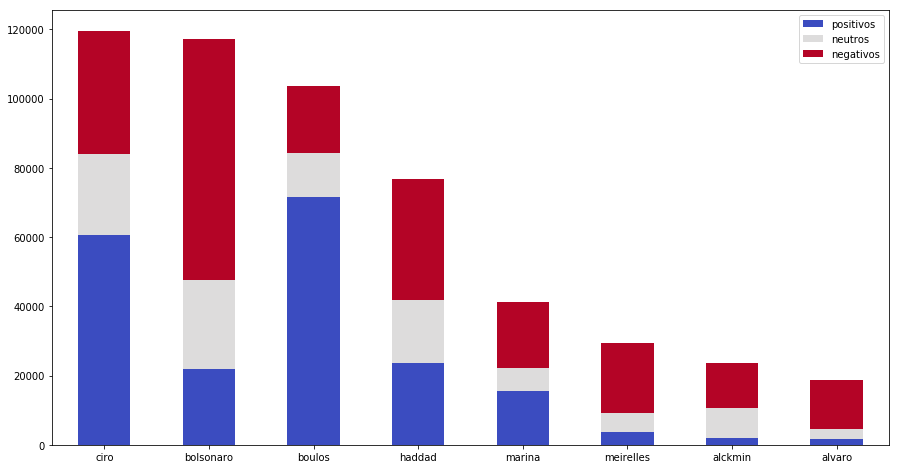

In [79]:
qtde_tweets_df.drop('total', axis=1).plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(15,8), rot=0);